# start

- http://localhost:8081/notebooks/git/recsys20/working/0324_6_3_lgb_feat_engr-1e7.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/mdl0404_1__xgb_mean_encode.ipynb
- http://localhost:8081/notebooks/git/recsys20/working/eda_0404_1.ipynb#v.s.-target
- https://www.kaggle.com/discdiver/category-encoders-examples
- https://www.kaggle.com/snakayama/lightgbm-using-optuna-optuna-lightgbm

In [1]:
TGT='Reply'
PRFX='Reply0411_1'

trntmstmp=1584412344
tsttmstmp=1586133347

tm_trn_min,tm_trn_max=(1580947200, 1581551999)
tm_tst_min,tm_tst_max=(1581552000, 1582156799)

SEED=101

valsz = int(5e5)#int(1e5)
trnsz = int(5e5)#int(5e5)

train_total=148075238
test_total=int(1.4e7)
print(f'train_total {train_total:,}, test_total {test_total:,}')


import datetime
def showtm(tm): return datetime.datetime.fromtimestamp(tm).strftime('%Y-%m-%d %H:%M:%S')
print([showtm(tm) for tm in (trntmstmp, tsttmstmp)])
print([showtm(tm) for tm in (tm_trn_min,tm_trn_max)])
print([showtm(tm) for tm in (tm_tst_min,tm_tst_max)])

train_total 148,075,238, test_total 14,000,000
['2020-03-17 02:32:24', '2020-04-06 00:35:47']
['2020-02-06 00:00:00', '2020-02-12 23:59:59']
['2020-02-13 00:00:00', '2020-02-19 23:59:59']


# setup

In [2]:
from tqdm import tqdm
import time
from pathlib import Path
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
# import xgboost as xgb
# import lightgbm as lgb
import category_encoders as ce
import gc

import optuna
# optuna.logging.CRITICAL, optuna.logging.FATAL
# optuna.logging.ERROR
# optuna.logging.WARNING, optuna.logging.WARN
# optuna.logging.INFO
# optuna.logging.DEBUG
# optuna.logging.set_verbosity(optuna.logging.ERROR)
import optuna.integration.lightgbm as lgb
optuna.logging.disable_default_handler()


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

def iou(s1,s2):
    return len(s1&s2) / len(s1|s2)

HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 
def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    (((1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)) +
     (data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop))))
    return calibrated_data


cols=['toks','hshtgs','twtid','media','links','domns','twttyp','lang','tm','u1id','u1_fllwer_cnt','u1_fllwing_cnt','u1_vrfed','u1_create_tm','u2id','u2_fllwer_cnt','u2_fllwng_cnt','u2_vrfed','u2_create_tm','u1_fllw_u2','reply_tm','retwt_tm','retwt_cmmnt_tm','like_tm',]

cols_val = cols[:-4]
cols_tgt_tmstmp=[ 'retwt_tm', 'reply_tm', 'like_tm', 'retwt_cmmnt_tm',]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
tgt2col = dict(zip(tgts, cols_tgt))
TCOL=tgt2col[TGT]
print('TCOL', TCOL)
print(tgt2col)

TCOL reply
{'Retweet': 'retwt', 'Reply': 'reply', 'Like': 'like', 'RTwCmnt': 'retwt_cmmnt'}


# prep

In [3]:
def prp_tgt(df):
    df[cols_tgt]=df[cols_tgt_tmstmp].notna()
    df.drop(columns=cols_tgt_tmstmp, inplace=True)
    display(df[cols_tgt].mean())

In [4]:
%%time
dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=valsz)
print(dfval.shape)
prp_tgt(dfval)

(500000, 24)


retwt          0.112638
reply          0.027980
like           0.439010
retwt_cmmnt    0.007676
dtype: float64

CPU times: user 5.33 s, sys: 560 ms, total: 5.89 s
Wall time: 6.18 s


## maybe oversample

In [5]:
# df = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=5)
# dfval = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,nrows=2)
# dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,skiprows=2,nrows=3)
# display(df.twtid)
# display(dfval.twtid)
# display(dftrn.twtid)

# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# 2    519078C7834E9642508F72A6C2D0F3B7
# 3    52AAE9E33EFAC8C478C57B31A9E31ED1
# 4    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object
# 0    D4D1EBDE74F74C5DA529959AF979625C
# 1    BFB529DAB6D384EB83E899A72AB3830D
# Name: twtid, dtype: object
# 0    519078C7834E9642508F72A6C2D0F3B7
# 1    52AAE9E33EFAC8C478C57B31A9E31ED1
# 2    89C1298C55EB3D68E2784F0BFB69E6F8
# Name: twtid, dtype: object

In [6]:
%%time
if TGT in ('Retweet','Like'): trnpop=trnsz
if TGT=='Reply': trnpop=trnsz*3.7
if TGT=='RTwCmnt': trnpop=trnsz*11.5
assert trnpop<train_total

dftrn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',header=None,names=cols,
                     skiprows=valsz, nrows=trnpop)
print(dftrn.shape)
prp_tgt(dftrn)

(1850000, 24)


retwt          0.112795
reply          0.027393
like           0.439040
retwt_cmmnt    0.007702
dtype: float64

CPU times: user 20.4 s, sys: 1.93 s, total: 22.4 s
Wall time: 22.9 s


In [7]:
train_pop=len(dftrn)
sampled_train_pop=trnsz
idx_pos = np.where(dftrn[TCOL])[0]
target_pop=sampled_target_pop=len(idx_pos)
if TGT in ('Reply','RTwCmnt'):
    idx_neg0 = np.where(~dftrn[TCOL])[0]
    idx_neg = np.random.choice(idx_neg0, trnsz-len(idx_pos), replace=False)
    idx = np.concatenate([idx_pos,idx_neg])
    dftrn = dftrn.iloc[idx].copy()
print(dftrn.shape, dftrn[TCOL].mean())
print(train_pop, target_pop, sampled_train_pop, sampled_target_pop)

display(dftrn.head())
display(dftrn.columns)

(500000, 24) 0.101354
1850000 50677 500000 50677


,toks,hshtgs,twtid,media,links,domns,twttyp,lang,tm,u1id,u1_fllwer_cnt,u1_fllwing_cnt,u1_vrfed,u1_create_tm,u2id,u2_fllwer_cnt,u2_fllwng_cnt,u2_vrfed,u2_create_tm,u1_fllw_u2,retwt,reply,like,retwt_cmmnt
9,101\t137\t48201\t10133\t44026\t10884\t11305\t9...,NaN,24669C0DADEA57A75F6BE24CAC0ACCB9,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1580948734,A6E0653718DB85566D3E6D1E2989AC6D,145,61,False,1522591408,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
11,101\t2341\t7911\t121\t12236\t7596\t7431\t12290...,NaN,E15A666B6A975581F5CE3F2286CDB408,Photo,NaN,NaN,TopLevel,22C448FF81263D4BAF2A176145EE9EAD,1581344753,74BD974C794C3C2D604E92F9402AB810,318,252,False,1464834037,06E9B9E30FB6A7F37CA6B42264C30103,407,385,False,1274938010,True,False,True,False,False
26,101\t144\t87051\t10354\t16874\t196\t10117\t172...,NaN,D8334D0798821B6A99A9C7A4C9E4E3E1,NaN,8FBB6E6890E2ED0F608F83345CB5EA2F,FFA7BC68DEEFEE9FE34F150D60FEA189,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1581149159,4CA2E59BBCCB899954E82B01D61C8DF1,16974,612,False,1397475686,06E9CB2FE3EE244FC5D3E2A7E0B7A460,66,512,False,1498734232,False,False,True,False,False
96,101\t11589\t39520\t18487\t58136\t10121\t10911\...,NaN,0C55DCB7494C90953ACE5E70A46B8AA9,NaN,NaN,NaN,TopLevel,06D61DCBBE938971E1EA0C38BD9B5446,1581470640,58867654CB709C6FBA4F332ED479EF1A,418,554,False,1354395470,06E9F8C1FB619A5AE34B3BE57632DB16,178,339,False,1538938782,True,False,True,True,False
303,101\t65000\t112\t188\t19556\t12172\t10133\t218...,NaN,3058691BBE196B9A3702A8E7584944E9,NaN,NaN,NaN,TopLevel,D3164C7FBCF2565DDF915B1B3AEFB1DC,1580980182,B31DCBBAE66B1E22B1531F77538E88E7,19,440,False,1476507467,06EADF03A34F162DE8051C27C439F6BB,172,167,False,1418024844,True,False,True,False,False


Index(['toks', 'hshtgs', 'twtid', 'media', 'links', 'domns', 'twttyp', 'lang',
       'tm', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed',
       'u1_create_tm', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u2_create_tm', 'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

## prep and features

In [8]:
def prp_df(df, tm_max):
    '''
    tm_max = tm_trn_max for train tm_tst_max for test
    '''
    lendf = len(df)
    print(dtnow(), 'start')
    set_u1 = set(df.u1id)
    set_u2 = set(df.u2id)
    df['u1inu2']=df.u1id.isin(set_u2)
    df['u2inu1']=df.u2id.isin(set_u1)

    #counts
    df['len_toks'] = df.toks.apply(lambda x: len(x.split('\t')))
    df.drop(columns=['toks'], inplace=True)    
    for m in ['Photo', 'Video', 'GIF']:
        df[f'n_media_{m}'] = df['media'].fillna('').apply(lambda x: x.split('\t').count(m))
    tgnms = ['hshtgs','media', 'links', 'domns',]
    for tgnm in tgnms:
        df[f'has_{tgnm}']=df[tgnm].notna()
        df[f'lst_{tgnm}'] = df[tgnm].fillna('').apply(lambda x: x.split('\t') if len(x) else [])
        df[f'n_{tgnm}'] = df[f'lst_{tgnm}'].apply(len)  
    df.drop(columns=['has_links','n_links'], inplace=True) #duplicates has_domns,n_domns 
    
    #time
    dt = pd.to_datetime(df.tm, unit='s')
    df['dayofweek'] = dt.dt.dayofweek
    df['hour'] = dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    df['twt_age']   = tm_max-df.tm
    df['u1_age']    = tm_max-df.u1_create_tm
    df['u2_age']    = tm_max-df.u2_create_tm
    df.drop(columns=['tm', 'u1_create_tm', 'u2_create_tm'], inplace=True)

    #time derived
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    #interaction
    df['u1u2']=df.u1id+'_'+df.u2id
    df['langhour']=df.lang+'_'+df.hour.astype(str)
    

    #freq of feature values
    print(dtnow(), 'freq of columns using CountEncoder')
    encoder = ce.CountEncoder()
    encoded = encoder.fit_transform(
    df[['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
       'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
       'dayofweek', 'hour', 'u1u2', 'langhour']].astype(object))
    encoded = encoded.astype(int)/lendf
    encoded.columns = [f'frq_{col}' for col in encoded.columns]
    df = pd.concat([df,encoded],1)
    
    #freq of tgnm values
    print(dtnow(), 'freq of tags')
    for tgnm in tgnms:
        vs = [j for i in df[f'lst_{tgnm}'] for j in i]
        cnt = Counter(vs)
        frq = {k:v/lendf for k,v in cnt.items()}
        df[f'sumfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: sum([frq.get(o,0) for o in x]))
        df[f'maxfrq_{tgnm}']=df[f'lst_{tgnm}'].apply(lambda x: max([frq.get(o,0) for o in x]) if len(x) else 0)
    df.drop(columns=tgnms+[f'lst_{tgnm}' for tgnm in tgnms],inplace=True)

    print(dtnow(), 'done')
    return df

In [9]:
%%time
dftrn=prp_df(dftrn, tm_max=tm_trn_max)

2020-04-11 20:05:22 start
2020-04-11 20:05:38 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:06:01 freq of tags
2020-04-11 20:06:08 done
CPU times: user 39.9 s, sys: 4.35 s, total: 44.2 s
Wall time: 46.4 s


In [10]:
%%time
dfval=prp_df(dfval, tm_max=tm_trn_max)

2020-04-11 20:06:09 start
2020-04-11 20:06:21 freq of columns using CountEncoder
2020-04-11 20:06:39 freq of tags
2020-04-11 20:06:46 done
CPU times: user 33.5 s, sys: 3.72 s, total: 37.3 s
Wall time: 37.5 s


## tr vl split and target encoding

In [11]:
msk_vl=np.random.rand(len(dftrn))<0.15
idxvl=np.where( msk_vl)[0]
idxtr=np.where(~msk_vl)[0]

dftr = dftrn.iloc[idxtr].copy()
dfvl = dftrn.iloc[idxvl].copy()
del dftrn

gc.collect()

30

In [12]:
dftr.columns

Index(['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwer_cnt', 'u1_fllwing_cnt',
       'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_fllwng_cnt', 'u2_vrfed',
       'u1_fllw_u2', 'retwt', 'reply', 'like', 'retwt_cmmnt', 'u1inu2',
       'u2inu1', 'len_toks', 'n_media_Photo', 'n_media_Video', 'n_media_GIF',
       'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media', 'has_domns',
       'n_domns', 'dayofweek', 'hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twt_age', 'u1_age', 'u2_age', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'u1u2', 'langhour', 'frq_twtid', 'frq_twttyp',
       'frq_lang', 'frq_u1id', 'frq_u1_fllwing_cnt', 'frq_u1_vrfed',
       'frq_u2id', 'frq_u2_fllwer_cnt', 'frq_u2_vrfed', 'frq_u1_fllw_u2',
       'frq_n_media_Photo', 'frq_n_media_Video', 'frq_n_media_GIF',
       'frq_has_hshtgs', 'frq_n_hshtgs', 'frq_has_media', 'frq_n_media',
       'frq_has_domns', 'frq_n_domns', 'frq_dayofweek', 'frq_hour', 'frq_u1u2',
       'frq_langhour', 'sumfrq_hshtgs', 

In [13]:
%%time
col2tgtenc=['twtid', 'twttyp', 'lang', 'u1id', 'u1_fllwing_cnt', 'u1_vrfed', 'u2id', 'u2_fllwer_cnt', 'u2_vrfed', 'u1_fllw_u2', 
   'n_media_Photo', 'n_media_Video', 'n_media_GIF', 
   'has_hshtgs', 'n_hshtgs', 'has_media', 'n_media','has_domns', 'n_domns', 
   'dayofweek', 'hour', 'u1u2', 'langhour']
tgt_encoder = ce.TargetEncoder()
encoded_tr = tgt_encoder.fit_transform(dftr[col2tgtenc].astype(object), dftr[TCOL])
encoded_vl = tgt_encoder.transform(dfvl[col2tgtenc].astype(object))
encoded_val = tgt_encoder.transform(dfval[col2tgtenc].astype(object))

tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tr.columns]
encoded_tr.columns = tgtenc_columns
encoded_vl.columns = tgtenc_columns
encoded_val.columns = tgtenc_columns

dftr = pd.concat([dftr, encoded_tr], 1)
dfvl = pd.concat([dfvl, encoded_vl], 1)
dfval = pd.concat([dfval, encoded_val], 1)


CPU times: user 37.3 s, sys: 6.95 s, total: 44.2 s
Wall time: 46.1 s


In [14]:
cols_category=['twttyp', 'lang', 'langhour']
for df in dftr,dfvl,dfval:
    df.drop(columns=['twtid','u1id','u2id','u1u2'], inplace=True)
    df[cols_category]=df[cols_category].astype('category')

In [15]:
cols_feat = [col for col in dftr.columns if col not in cols_tgt]

# model

## cols_feat

In [16]:
print(len(cols_feat))
cols_feat=['twttyp',
 'lang',
 'u1_fllwer_cnt',
 'u1_fllwing_cnt',
 'u1_vrfed',
 'u2_fllwer_cnt',
 'u2_fllwng_cnt',
 'u2_vrfed',
 'u1_fllw_u2',
 'u1inu2',
 'u2inu1',
 'len_toks',
 'n_media_Photo',
 'n_media_Video',
 'n_media_GIF',
#  'has_hshtgs',
 'n_hshtgs',
#  'has_media',
 'n_media',
#  'has_domns',
 'n_domns',
 'dayofweek',
 'hour',
 'tmdlta_u2u1',
 'tmdlta_twtu1',
 'tmdlta_twtu2',
 'twt_age',
 'u1_age',
 'u2_age',
 'u1_fllwer_cnt_by_age',
 'u1_fllwng_cnt_by_age',
 'langhour',
 'frq_twtid',
#  'frq_twttyp',
#  'frq_lang',
 'frq_u1id',
#  'frq_u1_fllwing_cnt',
#  'frq_u1_vrfed',
 'frq_u2id',
#  'frq_u2_fllwer_cnt',
#  'frq_u2_vrfed',
#  'frq_u1_fllw_u2',
#  'frq_n_media_Photo',
#  'frq_n_media_Video',
#  'frq_n_media_GIF',
#  'frq_has_hshtgs',
#  'frq_n_hshtgs',
#  'frq_has_media',
#  'frq_n_media',
#  'frq_has_domns',
#  'frq_n_domns',
#  'frq_dayofweek',
#  'frq_hour',
 'frq_u1u2',
#  'frq_langhour',
 'sumfrq_hshtgs',
#  'maxfrq_hshtgs',
#  'sumfrq_media',
#  'maxfrq_media',
#  'sumfrq_links',
#  'maxfrq_links',
 'sumfrq_domns',
#  'maxfrq_domns',
#  'tgtenc_twtid',
#  'tgtenc_twttyp',
#  'tgtenc_lang',
#  'tgtenc_u1id',
#  'tgtenc_u1_fllwing_cnt',
#  'tgtenc_u1_vrfed',
#  'tgtenc_u2id',
#  'tgtenc_u2_fllwer_cnt',
#  'tgtenc_u2_vrfed',
#  'tgtenc_u1_fllw_u2',
#  'tgtenc_n_media_Photo',
#  'tgtenc_n_media_Video',
#  'tgtenc_n_media_GIF',
#  'tgtenc_has_hshtgs',
#  'tgtenc_n_hshtgs',
#  'tgtenc_has_media',
#  'tgtenc_n_media',
#  'tgtenc_has_domns',
#  'tgtenc_n_domns',
#  'tgtenc_dayofweek',
#  'tgtenc_hour',
#  'tgtenc_u1u2',
#  'tgtenc_langhour'
          ]
print(len(cols_feat))

86
35


In [17]:
results = {}
results['PRFX'] = PRFX
results['TGT'] = TGT
results['cols_feat'] = cols_feat
results['tgt_encoder'] = tgt_encoder
results['col2tgtenc'] = col2tgtenc

In [18]:
params={
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': 0,    
}
results['params'] = params

In [19]:
%%time
dtr = lgb.Dataset(dftr[cols_feat], label=dftr[TCOL])
dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[TCOL])
best_params, tuning_history = {}, []
evalres = {}
evallist = [(dtr, 'train'), (dvl, 'eval')]
bst = lgb.train(params=params, 
                train_set=dtr, 
                num_boost_round=50000,
                valid_sets=[dtr, dvl],
                valid_names=['tr','vl'],
                best_params=best_params,
                tuning_history=tuning_history,
                verbose_eval=100,
                early_stopping_rounds=100,
                evals_result=evalres,
               )
results['bst'] = bst
results['evalres'] = evalres
results['best_params']=best_params
results['tuning_history']=tuning_history

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/optuna/_experimental.py:87: ExperimentalWarning: train is experimental (supported from v0.18.0). The interface can change in the future.
  ExperimentalWarning
tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.270617	vl's binary_logloss: 0.281291
[200]	tr's binary_logloss: 0.264368	vl's binary_logloss: 0.280852
[300]	tr's binary_logloss: 0.259204	vl's binary_logloss: 0.280831
Early stopping, best iteration is:
[220]	tr's binary_logloss: 0.263277	vl's binary_logloss: 0.280772


tune_feature_fraction, val_score: 0.280772:  14%|#4        | 1/7 [00:17<01:45, 17.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269557	vl's binary_logloss: 0.281202
[200]	tr's binary_logloss: 0.262742	vl's binary_logloss: 0.281018
[300]	tr's binary_logloss: 0.25725	vl's binary_logloss: 0.280942
Early stopping, best iteration is:
[265]	tr's binary_logloss: 0.259209	vl's binary_logloss: 0.28085


tune_feature_fraction, val_score: 0.280772:  29%|##8       | 2/7 [00:33<01:25, 17.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.269164	vl's binary_logloss: 0.281435
[200]	tr's binary_logloss: 0.261706	vl's binary_logloss: 0.281123
[300]	tr's binary_logloss: 0.255683	vl's binary_logloss: 0.281177
Early stopping, best iteration is:
[262]	tr's binary_logloss: 0.258112	vl's binary_logloss: 0.281044


tune_feature_fraction, val_score: 0.280772:  43%|####2     | 3/7 [00:51<01:08, 17.20s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.268477	vl's binary_logloss: 0.281608
[200]	tr's binary_logloss: 0.261017	vl's binary_logloss: 0.281414
Early stopping, best iteration is:
[149]	tr's binary_logloss: 0.26451	vl's binary_logloss: 0.281389


tune_feature_fraction, val_score: 0.280772:  57%|#####7    | 4/7 [01:04<00:47, 15.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.267819	vl's binary_logloss: 0.281917
[200]	tr's binary_logloss: 0.259986	vl's binary_logloss: 0.281763
Early stopping, best iteration is:
[173]	tr's binary_logloss: 0.261978	vl's binary_logloss: 0.281674


tune_feature_fraction, val_score: 0.280772:  71%|#######1  | 5/7 [01:18<00:30, 15.49s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.26695	vl's binary_logloss: 0.282076
[200]	tr's binary_logloss: 0.258943	vl's binary_logloss: 0.282059
Early stopping, best iteration is:
[144]	tr's binary_logloss: 0.26307	vl's binary_logloss: 0.28188


tune_feature_fraction, val_score: 0.280772:  86%|########5 | 6/7 [01:32<00:14, 14.97s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266182	vl's binary_logloss: 0.282619
Early stopping, best iteration is:
[80]	tr's binary_logloss: 0.268368	vl's binary_logloss: 0.282532


tune_num_leaves, val_score: 0.280772:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.234449	vl's binary_logloss: 0.281626
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.247423	vl's binary_logloss: 0.281336


tune_num_leaves, val_score: 0.280772:   5%|5         | 1/20 [00:23<07:25, 23.46s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.237252	vl's binary_logloss: 0.281138
Early stopping, best iteration is:
[71]	tr's binary_logloss: 0.247102	vl's binary_logloss: 0.280967


tune_num_leaves, val_score: 0.280772:  10%|#         | 2/20 [00:52<07:30, 25.03s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.245947	vl's binary_logloss: 0.280951
[200]	tr's binary_logloss: 0.226316	vl's binary_logloss: 0.281222
Early stopping, best iteration is:
[120]	tr's binary_logloss: 0.241147	vl's binary_logloss: 0.280773


tune_num_leaves, val_score: 0.280772:  15%|#5        | 3/20 [01:18<07:08, 25.22s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.232467	vl's binary_logloss: 0.281762
Early stopping, best iteration is:
[65]	tr's binary_logloss: 0.245734	vl's binary_logloss: 0.281499


tune_num_leaves, val_score: 0.280772:  20%|##        | 4/20 [01:40<06:30, 24.41s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.240723	vl's binary_logloss: 0.281327
Early stopping, best iteration is:
[70]	tr's binary_logloss: 0.25021	vl's binary_logloss: 0.281074


tune_num_leaves, val_score: 0.280772:  25%|##5       | 5/20 [01:57<05:34, 22.27s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.236812	vl's binary_logloss: 0.281231
Early stopping, best iteration is:
[71]	tr's binary_logloss: 0.246677	vl's binary_logloss: 0.281131


tune_num_leaves, val_score: 0.280772:  30%|###       | 6/20 [02:20<05:15, 22.53s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.2741	vl's binary_logloss: 0.281579
[200]	tr's binary_logloss: 0.269093	vl's binary_logloss: 0.280873
[300]	tr's binary_logloss: 0.26498	vl's binary_logloss: 0.280669
Early stopping, best iteration is:
[297]	tr's binary_logloss: 0.265116	vl's binary_logloss: 0.280647


tune_num_leaves, val_score: 0.280647:  35%|###5      | 7/20 [02:38<04:34, 21.12s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.257197	vl's binary_logloss: 0.280554
[200]	tr's binary_logloss: 0.243893	vl's binary_logloss: 0.280564
Early stopping, best iteration is:
[150]	tr's binary_logloss: 0.250063	vl's binary_logloss: 0.28037


tune_num_leaves, val_score: 0.280370:  40%|####      | 8/20 [02:49<03:36, 18.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.236152	vl's binary_logloss: 0.281455
Early stopping, best iteration is:
[69]	tr's binary_logloss: 0.246941	vl's binary_logloss: 0.281154


tune_num_leaves, val_score: 0.280370:  45%|####5     | 9/20 [03:00<02:53, 15.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250211	vl's binary_logloss: 0.280411
[200]	tr's binary_logloss: 0.232885	vl's binary_logloss: 0.28075
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248214	vl's binary_logloss: 0.280363


tune_num_leaves, val_score: 0.280363:  50%|#####     | 10/20 [03:10<02:20, 14.09s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25776	vl's binary_logloss: 0.280667
[200]	tr's binary_logloss: 0.244573	vl's binary_logloss: 0.280828
Early stopping, best iteration is:
[130]	tr's binary_logloss: 0.253243	vl's binary_logloss: 0.280499


tune_num_leaves, val_score: 0.280363:  55%|#####5    | 11/20 [03:19<01:54, 12.71s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25776	vl's binary_logloss: 0.280667
[200]	tr's binary_logloss: 0.244573	vl's binary_logloss: 0.280828
Early stopping, best iteration is:
[130]	tr's binary_logloss: 0.253243	vl's binary_logloss: 0.280499


tune_num_leaves, val_score: 0.280363:  60%|######    | 12/20 [03:29<01:33, 11.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25568	vl's binary_logloss: 0.280827
[200]	tr's binary_logloss: 0.241557	vl's binary_logloss: 0.28091
Early stopping, best iteration is:
[120]	tr's binary_logloss: 0.252211	vl's binary_logloss: 0.28069


tune_num_leaves, val_score: 0.280363:  65%|######5   | 13/20 [03:38<01:17, 11.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.271619	vl's binary_logloss: 0.281322
[200]	tr's binary_logloss: 0.26583	vl's binary_logloss: 0.280884
[300]	tr's binary_logloss: 0.260763	vl's binary_logloss: 0.280824
Early stopping, best iteration is:
[251]	tr's binary_logloss: 0.263278	vl's binary_logloss: 0.280643


tune_num_leaves, val_score: 0.280363:  70%|#######   | 14/20 [03:49<01:06, 11.01s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249476	vl's binary_logloss: 0.28088
[200]	tr's binary_logloss: 0.232406	vl's binary_logloss: 0.281186
Early stopping, best iteration is:
[147]	tr's binary_logloss: 0.240796	vl's binary_logloss: 0.28077


tune_num_leaves, val_score: 0.280363:  75%|#######5  | 15/20 [04:01<00:56, 11.30s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.265577	vl's binary_logloss: 0.280839
[200]	tr's binary_logloss: 0.256563	vl's binary_logloss: 0.280705
[300]	tr's binary_logloss: 0.249179	vl's binary_logloss: 0.280824
Early stopping, best iteration is:
[229]	tr's binary_logloss: 0.25432	vl's binary_logloss: 0.280634


tune_num_leaves, val_score: 0.280363:  80%|########  | 16/20 [04:12<00:44, 11.21s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.243406	vl's binary_logloss: 0.280841
Early stopping, best iteration is:
[83]	tr's binary_logloss: 0.248207	vl's binary_logloss: 0.280783


tune_num_leaves, val_score: 0.280363:  85%|########5 | 17/20 [04:22<00:32, 10.90s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252425	vl's binary_logloss: 0.280429
[200]	tr's binary_logloss: 0.236787	vl's binary_logloss: 0.280682
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.250517	vl's binary_logloss: 0.280387


tune_num_leaves, val_score: 0.280363:  90%|######### | 18/20 [04:32<00:21, 10.69s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.266361	vl's binary_logloss: 0.281012
[200]	tr's binary_logloss: 0.258161	vl's binary_logloss: 0.280663
[300]	tr's binary_logloss: 0.251175	vl's binary_logloss: 0.280835
Early stopping, best iteration is:
[229]	tr's binary_logloss: 0.256031	vl's binary_logloss: 0.280632


tune_num_leaves, val_score: 0.280363:  95%|#########5| 19/20 [04:43<00:10, 10.72s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.263323	vl's binary_logloss: 0.280579
[200]	tr's binary_logloss: 0.253362	vl's binary_logloss: 0.280482
Early stopping, best iteration is:
[135]	tr's binary_logloss: 0.259496	vl's binary_logloss: 0.280391


tune_num_leaves, val_score: 0.280363: 100%|##########| 20/20 [04:52<00:00, 14.64s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.253255	vl's binary_logloss: 0.28131
[200]	tr's binary_logloss: 0.235233	vl's binary_logloss: 0.281865
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.251616	vl's binary_logloss: 0.28126


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  10%|#         | 1/10 [00:13<02:03, 13.70s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252695	vl's binary_logloss: 0.28154
[200]	tr's binary_logloss: 0.234645	vl's binary_logloss: 0.28188
Early stopping, best iteration is:
[104]	tr's binary_logloss: 0.25187	vl's binary_logloss: 0.281499


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  20%|##        | 2/10 [00:27<01:50, 13.79s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252526	vl's binary_logloss: 0.281717
Early stopping, best iteration is:
[86]	tr's binary_logloss: 0.255711	vl's binary_logloss: 0.281539


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  30%|###       | 3/10 [00:40<01:33, 13.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252372	vl's binary_logloss: 0.280935
[200]	tr's binary_logloss: 0.234157	vl's binary_logloss: 0.28154
Early stopping, best iteration is:
[101]	tr's binary_logloss: 0.252173	vl's binary_logloss: 0.280891


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  40%|####      | 4/10 [00:54<01:22, 13.78s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252069	vl's binary_logloss: 0.280854
[200]	tr's binary_logloss: 0.234388	vl's binary_logloss: 0.281594
Early stopping, best iteration is:
[101]	tr's binary_logloss: 0.251852	vl's binary_logloss: 0.280831


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  50%|#####     | 5/10 [01:09<01:10, 14.08s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252351	vl's binary_logloss: 0.281376
Early stopping, best iteration is:
[86]	tr's binary_logloss: 0.255548	vl's binary_logloss: 0.28134


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  60%|######    | 6/10 [01:23<00:56, 14.11s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251627	vl's binary_logloss: 0.281264
[200]	tr's binary_logloss: 0.234005	vl's binary_logloss: 0.281699
Early stopping, best iteration is:
[126]	tr's binary_logloss: 0.246459	vl's binary_logloss: 0.28113


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  70%|#######   | 7/10 [01:39<00:43, 14.51s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251736	vl's binary_logloss: 0.280855
[200]	tr's binary_logloss: 0.23413	vl's binary_logloss: 0.281477
Early stopping, best iteration is:
[119]	tr's binary_logloss: 0.247992	vl's binary_logloss: 0.280789


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  80%|########  | 8/10 [01:54<00:29, 14.74s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254716	vl's binary_logloss: 0.282533
Early stopping, best iteration is:
[85]	tr's binary_logloss: 0.25785	vl's binary_logloss: 0.282257


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363:  90%|######### | 9/10 [02:07<00:14, 14.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254294	vl's binary_logloss: 0.282339
Early stopping, best iteration is:
[73]	tr's binary_logloss: 0.260454	vl's binary_logloss: 0.282284


tune_bagging_fraction_and_bagging_freq, val_score: 0.280363: 100%|##########| 10/10 [02:18<00:00, 13.90s/it]
tune_feature_fraction, val_score: 0.280363:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.24984	vl's binary_logloss: 0.280909
Early stopping, best iteration is:
[81]	tr's binary_logloss: 0.254402	vl's binary_logloss: 0.280818


tune_feature_fraction, val_score: 0.280363:  33%|###3      | 1/3 [00:11<00:22, 11.40s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249091	vl's binary_logloss: 0.280841
[200]	tr's binary_logloss: 0.232119	vl's binary_logloss: 0.281328
Early stopping, best iteration is:
[109]	tr's binary_logloss: 0.247289	vl's binary_logloss: 0.280748


tune_feature_fraction, val_score: 0.280363:  67%|######6   | 2/3 [00:24<00:11, 11.87s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.248909	vl's binary_logloss: 0.281065
Early stopping, best iteration is:
[67]	tr's binary_logloss: 0.256834	vl's binary_logloss: 0.280993


tune_feature_fraction, val_score: 0.280363: 100%|##########| 3/3 [00:35<00:00, 11.95s/it]
tune_lambda_l1_and_lambda_l2, val_score: 0.280363:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250122	vl's binary_logloss: 0.280945
Early stopping, best iteration is:
[83]	tr's binary_logloss: 0.254079	vl's binary_logloss: 0.28089


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:   5%|5         | 1/20 [00:11<03:39, 11.54s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250615	vl's binary_logloss: 0.280695
[200]	tr's binary_logloss: 0.23369	vl's binary_logloss: 0.280752
Early stopping, best iteration is:
[157]	tr's binary_logloss: 0.240393	vl's binary_logloss: 0.280543


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  10%|#         | 2/20 [00:27<03:53, 12.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250342	vl's binary_logloss: 0.280438
[200]	tr's binary_logloss: 0.233675	vl's binary_logloss: 0.280801
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248375	vl's binary_logloss: 0.280396


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  15%|#5        | 3/20 [00:41<03:42, 13.07s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251554	vl's binary_logloss: 0.2807
[200]	tr's binary_logloss: 0.235372	vl's binary_logloss: 0.280962
Early stopping, best iteration is:
[109]	tr's binary_logloss: 0.249793	vl's binary_logloss: 0.280626


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  20%|##        | 4/20 [00:57<03:43, 13.95s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250375	vl's binary_logloss: 0.280645
[200]	tr's binary_logloss: 0.233227	vl's binary_logloss: 0.281277
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.24831	vl's binary_logloss: 0.280529


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  25%|##5       | 5/20 [01:15<03:48, 15.25s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.25432	vl's binary_logloss: 0.280701
[200]	tr's binary_logloss: 0.240931	vl's binary_logloss: 0.280813
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.252997	vl's binary_logloss: 0.28057


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  30%|###       | 6/20 [01:43<04:24, 18.92s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250337	vl's binary_logloss: 0.281003
[200]	tr's binary_logloss: 0.233594	vl's binary_logloss: 0.281221
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.248659	vl's binary_logloss: 0.280908


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  35%|###5      | 7/20 [02:03<04:09, 19.23s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249987	vl's binary_logloss: 0.280717
[200]	tr's binary_logloss: 0.233194	vl's binary_logloss: 0.281395
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.248334	vl's binary_logloss: 0.280606


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  40%|####      | 8/20 [02:25<04:02, 20.24s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.254393	vl's binary_logloss: 0.280543
[200]	tr's binary_logloss: 0.240426	vl's binary_logloss: 0.280874
Early stopping, best iteration is:
[103]	tr's binary_logloss: 0.253902	vl's binary_logloss: 0.280505


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  45%|####5     | 9/20 [02:44<03:36, 19.67s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250392	vl's binary_logloss: 0.280736
[200]	tr's binary_logloss: 0.233566	vl's binary_logloss: 0.281244
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248505	vl's binary_logloss: 0.280684


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  50%|#####     | 10/20 [03:04<03:17, 19.80s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250231	vl's binary_logloss: 0.280398
Early stopping, best iteration is:
[99]	tr's binary_logloss: 0.250392	vl's binary_logloss: 0.280384


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  55%|#####5    | 11/20 [03:19<02:46, 18.55s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250231	vl's binary_logloss: 0.280398
Early stopping, best iteration is:
[99]	tr's binary_logloss: 0.250392	vl's binary_logloss: 0.280384


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  60%|######    | 12/20 [03:36<02:25, 18.16s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250211	vl's binary_logloss: 0.280411
[200]	tr's binary_logloss: 0.232885	vl's binary_logloss: 0.28075
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248214	vl's binary_logloss: 0.280363


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  65%|######5   | 13/20 [03:59<02:16, 19.50s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250211	vl's binary_logloss: 0.280411
[200]	tr's binary_logloss: 0.232885	vl's binary_logloss: 0.28075
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248214	vl's binary_logloss: 0.280363


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  70%|#######   | 14/20 [04:17<01:54, 19.13s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250211	vl's binary_logloss: 0.280411
[200]	tr's binary_logloss: 0.232885	vl's binary_logloss: 0.28075
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248214	vl's binary_logloss: 0.280363


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  75%|#######5  | 15/20 [04:43<01:45, 21.14s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250211	vl's binary_logloss: 0.280411
[200]	tr's binary_logloss: 0.232885	vl's binary_logloss: 0.28075
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248214	vl's binary_logloss: 0.280363


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  80%|########  | 16/20 [05:00<01:19, 19.98s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250211	vl's binary_logloss: 0.280411
[200]	tr's binary_logloss: 0.232885	vl's binary_logloss: 0.28075
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248214	vl's binary_logloss: 0.280363


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  85%|########5 | 17/20 [05:24<01:03, 21.15s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250211	vl's binary_logloss: 0.280411
[200]	tr's binary_logloss: 0.232885	vl's binary_logloss: 0.28075
Early stopping, best iteration is:
[110]	tr's binary_logloss: 0.248215	vl's binary_logloss: 0.280363


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  90%|######### | 18/20 [05:44<00:41, 20.68s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250231	vl's binary_logloss: 0.280398
Early stopping, best iteration is:
[99]	tr's binary_logloss: 0.250392	vl's binary_logloss: 0.280384


tune_lambda_l1_and_lambda_l2, val_score: 0.280363:  95%|#########5| 19/20 [06:07<00:21, 21.52s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250098	vl's binary_logloss: 0.281057
[200]	tr's binary_logloss: 0.233008	vl's binary_logloss: 0.281492
Early stopping, best iteration is:
[114]	tr's binary_logloss: 0.247274	vl's binary_logloss: 0.281025


tune_lambda_l1_and_lambda_l2, val_score: 0.280363: 100%|##########| 20/20 [06:30<00:00, 19.54s/it]
tune_min_child_samples, val_score: 0.280363:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.248437	vl's binary_logloss: 0.281167
[200]	tr's binary_logloss: 0.229626	vl's binary_logloss: 0.281545
Early stopping, best iteration is:
[107]	tr's binary_logloss: 0.246791	vl's binary_logloss: 0.281075


tune_min_child_samples, val_score: 0.280363:  20%|##        | 1/5 [00:16<01:04, 16.10s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.249288	vl's binary_logloss: 0.280927
[200]	tr's binary_logloss: 0.2313	vl's binary_logloss: 0.28109
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.24754	vl's binary_logloss: 0.280859


tune_min_child_samples, val_score: 0.280363:  40%|####      | 2/5 [00:33<00:49, 16.37s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.250533	vl's binary_logloss: 0.280812
[200]	tr's binary_logloss: 0.233577	vl's binary_logloss: 0.281484
Early stopping, best iteration is:
[108]	tr's binary_logloss: 0.248868	vl's binary_logloss: 0.280719


tune_min_child_samples, val_score: 0.280363:  60%|######    | 3/5 [00:54<00:35, 17.85s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.251207	vl's binary_logloss: 0.28088
[200]	tr's binary_logloss: 0.235112	vl's binary_logloss: 0.2812
Early stopping, best iteration is:
[123]	tr's binary_logloss: 0.246939	vl's binary_logloss: 0.280779


tune_min_child_samples, val_score: 0.280363:  80%|########  | 4/5 [01:20<00:20, 20.42s/it]

Training until validation scores don't improve for 100 rounds
[100]	tr's binary_logloss: 0.252244	vl's binary_logloss: 0.280796
[200]	tr's binary_logloss: 0.236388	vl's binary_logloss: 0.281044
Early stopping, best iteration is:
[135]	tr's binary_logloss: 0.246125	vl's binary_logloss: 0.280672


tune_min_child_samples, val_score: 0.280363: 100%|##########| 5/5 [01:41<00:00, 20.31s/it]


CPU times: user 1h 5min 37s, sys: 1h 54min 42s, total: 3h 19s
Wall time: 17min 43s


## best_params

In [20]:
best_params

{'lambda_l1': 1.619448041355215e-07,
 'lambda_l2': 5.392846308636591e-06,
 'num_leaves': 129,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

## tr vl trajec

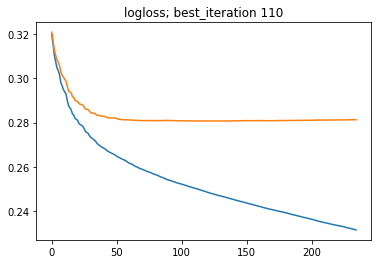

In [21]:
plt.plot(evalres['tr']['binary_logloss'])
plt.plot(evalres['vl']['binary_logloss'])
plt.title(f"logloss; best_iteration {bst.best_iteration}")
plt.show()

## model features

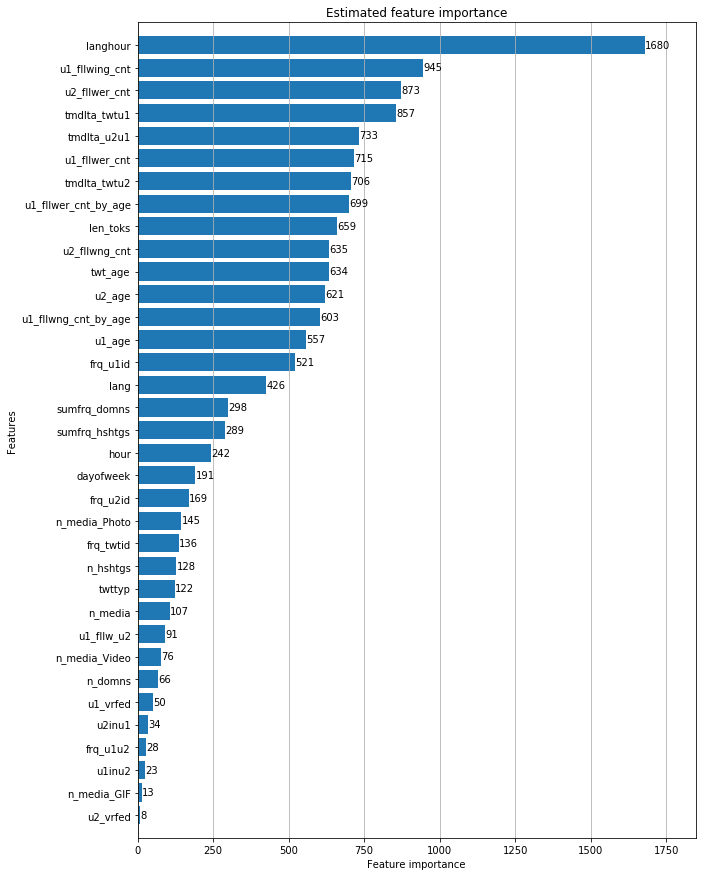

In [22]:
ax = lgb.plot_importance(bst, height=0.8, max_num_features=50, figsize=(10,15))
ax.grid(False, axis="y")
ax.set_title(f'Estimated feature importance')
plt.show()

In [23]:
pd.DataFrame([bst.feature_name(), bst.feature_importance()]).T.sort_values(1, ascending=False)

,0,1
28,langhour,1680
3,u1_fllwing_cnt,945
5,u2_fllwer_cnt,873
21,tmdlta_twtu1,857
20,tmdlta_u2u1,733
2,u1_fllwer_cnt,715
22,tmdlta_twtu2,706
26,u1_fllwer_cnt_by_age,699
11,len_toks,659
6,u2_fllwng_cnt,635


In [24]:
col2imp = dict(zip(bst.feature_name(), bst.feature_importance()))
sorted(col2imp.items(), key=lambda x: -x[1])

[('langhour', 1680),
 ('u1_fllwing_cnt', 945),
 ('u2_fllwer_cnt', 873),
 ('tmdlta_twtu1', 857),
 ('tmdlta_u2u1', 733),
 ('u1_fllwer_cnt', 715),
 ('tmdlta_twtu2', 706),
 ('u1_fllwer_cnt_by_age', 699),
 ('len_toks', 659),
 ('u2_fllwng_cnt', 635),
 ('twt_age', 634),
 ('u2_age', 621),
 ('u1_fllwng_cnt_by_age', 603),
 ('u1_age', 557),
 ('frq_u1id', 521),
 ('lang', 426),
 ('sumfrq_domns', 298),
 ('sumfrq_hshtgs', 289),
 ('hour', 242),
 ('dayofweek', 191),
 ('frq_u2id', 169),
 ('n_media_Photo', 145),
 ('frq_twtid', 136),
 ('n_hshtgs', 128),
 ('twttyp', 122),
 ('n_media', 107),
 ('u1_fllw_u2', 91),
 ('n_media_Video', 76),
 ('n_domns', 66),
 ('u1_vrfed', 50),
 ('u2inu1', 34),
 ('frq_u1u2', 28),
 ('u1inu2', 23),
 ('n_media_GIF', 13),
 ('u2_vrfed', 8)]

In [25]:
[o[0] for o in sorted(col2imp.items(), key=lambda x: -x[1]) if o[1]>0]

['langhour',
 'u1_fllwing_cnt',
 'u2_fllwer_cnt',
 'tmdlta_twtu1',
 'tmdlta_u2u1',
 'u1_fllwer_cnt',
 'tmdlta_twtu2',
 'u1_fllwer_cnt_by_age',
 'len_toks',
 'u2_fllwng_cnt',
 'twt_age',
 'u2_age',
 'u1_fllwng_cnt_by_age',
 'u1_age',
 'frq_u1id',
 'lang',
 'sumfrq_domns',
 'sumfrq_hshtgs',
 'hour',
 'dayofweek',
 'frq_u2id',
 'n_media_Photo',
 'frq_twtid',
 'n_hshtgs',
 'twttyp',
 'n_media',
 'u1_fllw_u2',
 'n_media_Video',
 'n_domns',
 'u1_vrfed',
 'u2inu1',
 'frq_u1u2',
 'u1inu2',
 'n_media_GIF',
 'u2_vrfed']

# eval

In [26]:
%%time
prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
prdval0 = bst.predict(dfval[cols_feat],num_iteration=bst.best_iteration)
prdval = calibration(prdval0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 38.2 s, sys: 2.5 s, total: 40.7 s
Wall time: 9.3 s


In [27]:
%%time
ytr,yvl,yval=[df[TCOL].values for df in (dftr,dfvl,dfval)]

auc_tr=compute_prauc(prdtr, ytr)
rce_tr=compute_rce(prdtr, ytr)
auc_vl=compute_prauc(prdvl, yvl)
rce_vl=compute_rce(prdvl, yvl)
auc_val=compute_prauc(prdval, yval)
rce_val=compute_rce(prdval, yval)

results['scrs'] = {}
results['scrs']['auc_tr']=auc_tr
results['scrs']['rce_tr']=rce_tr
results['scrs']['auc_vl']=auc_vl
results['scrs']['rce_vl']=rce_vl
results['scrs']['auc_val']=auc_val
results['scrs']['rce_val']=rce_val

CPU times: user 5.8 s, sys: 197 ms, total: 6 s
Wall time: 5.83 s


In [28]:
print(f'auc_tr:  {auc_tr:.4f}')
print(f'auc_vl:  {auc_vl:.4f}')
print(f'auc_val: {auc_val:.4f}')
print()
print(f'rce_tr:  {rce_tr:.4f}')
print(f'rce_vl:  {rce_vl:.4f}')
print(f'rce_val: {rce_val:.4f}')

auc_tr:  0.4436
auc_vl:  0.2956
auc_val: 0.1018

rce_tr:  24.3155
rce_vl:  14.6666
rce_val: 11.3048


## score

In [29]:
print(f'-{auc_val:.4f}-{rce_val:.4f}')

-0.1018-11.3048


# save results

In [30]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))

# infer

In [31]:
results = pickle.load( open(f'{p_out}/results_{PRFX}.p', 'rb'))
bst = results['bst']
col2tgtenc = results['col2tgtenc']
cols_feat = results['cols_feat']
tgt_encoder = results['tgt_encoder']

## prep

In [32]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{tsttmstmp}.tsv',
    sep='\x01', header=None, names=cols_val, 
    nrows=10
)

CPU times: user 8.99 ms, sys: 1.02 ms, total: 10 ms
Wall time: 8.83 ms


In [33]:
%%time
dftst=prp_df(dftst, tm_max=tm_tst_max)

2020-04-11 20:25:41 start
2020-04-11 20:25:41 freq of columns using CountEncoder


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


2020-04-11 20:25:41 freq of tags
2020-04-11 20:25:41 done
CPU times: user 207 ms, sys: 3.38 ms, total: 210 ms
Wall time: 237 ms


In [34]:
encoded_tst = tgt_encoder.transform(dftst[col2tgtenc].astype(object))
tgtenc_columns = [f'tgtenc_{col}' for col in encoded_tst.columns]
encoded_tst.columns = tgtenc_columns
dftst = pd.concat([dftst, encoded_tst], 1)
dftst.drop(columns=['u1id','u1u2'], inplace=True)
cols_category=['twttyp', 'lang', 'langhour']
dftst[cols_category]=dftst[cols_category].astype('category')

## predict

In [35]:
%%time
prdtst0 = bst.predict(dftst[cols_feat],num_iteration=bst.best_iteration)
prdtst = calibration(prdtst0, train_pop, target_pop, sampled_train_pop, sampled_target_pop)

CPU times: user 52.6 ms, sys: 95.3 ms, total: 148 ms
Wall time: 51.6 ms


In [36]:
dfsub_ids = dftst[['twtid','u2id',]]
dfsub = dfsub_ids.copy()
dfsub['scr'] = prdtst
dfsub.to_csv(f'{p_out}/{TGT}__{PRFX}.csv',index=False,header=False)